In [22]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc

In [23]:
drive.mount('/content/drive/', force_remount=False)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
%cd '/content/drive/My Drive/DxA_Case_Study'

/content/drive/My Drive/DxA_Case_Study


In [25]:
df=pd.read_csv('churn_data.csv')

**Churn Data**

*   Data consist of 50079 customers and no missing values for target variable churn.

*   But we need to take care of other variables with missing observations.




In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50079 entries, 0 to 50078
Data columns (total 100 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer_ID       50079 non-null  int64  
 1   rev_Mean          49932 non-null  float64
 2   mou_Mean          49932 non-null  float64
 3   totmrc_Mean       49932 non-null  float64
 4   da_Mean           49932 non-null  float64
 5   ovrmou_Mean       49932 non-null  float64
 6   ovrrev_Mean       49932 non-null  float64
 7   vceovr_Mean       49932 non-null  float64
 8   datovr_Mean       49932 non-null  float64
 9   roam_Mean         49932 non-null  float64
 10  change_mou        49677 non-null  float64
 11  change_rev        49677 non-null  float64
 12  drop_vce_Mean     50079 non-null  float64
 13  drop_dat_Mean     50079 non-null  float64
 14  blck_vce_Mean     50079 non-null  float64
 15  blck_dat_Mean     50079 non-null  float64
 16  unan_vce_Mean     50079 non-null  float

In [27]:
df=df.drop(['Customer_ID'],axis=1)
df.describe()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,months,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,lor,adults,income,numbcars,forgntvl,eqpdays,churn
count,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49932.000000,49677.000000,49677.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,50079.000000,48653.000000,48653.000000,48653.000000,49657.000000,50078.000000,50078.000000,49175.000000,49175.000000,34951.000000,38607.000000,37369.000000,25329.000000,49175.000000,50078.000000,50079.000000
mean,58.605808,511.867777,46.170711,0.886424,41.206099,13.582805,13.318369,0.261355,1.202173,-14.445552,-1.226900,5.937908,0.039538,4.000586,0.026618,27.688948,0.028049,144.606715,0.894823,54.886676,0.047591,108.751343,0.800618,1.798315,4.697252,3.711898,29.720668,0.283738,227.105455,1.945585,111.190666,24.701944,28.409820,7.879331,18.159519,88.265757,0.367749,173.315459,0.741233,65.900367,0.432876,164.920764,1.204352,10.004649,145.501538,109.551961,0.015416,1.780850,18.804808,1.550670,1.359352,2868.507099,7619.832429,1028.524567,956.821423,7517.753004,2827.581202,57.809374,482.547604,173.454179,518.330358,180.084526,59.165219,508.354017,178.133702,58.616283,102.150210,1.782619,1.543652,0.188429,0.082298,6.214214,2.533452,5.789531,1.569624,0.058343,392.159451,0.498013
std,44.432651,523.521413,23.700695,2.187620,98.741371,30.712862,30.319873,3.257460,7.411250,255.881698,37.593972,9.002923,0.561388,10.704397,1.930457,38.356642,0.422758,158.913263,8.925890,85.516149,1.630220,119.211623,8.027889,5.674131,12.829220,10.545214,54.702067,1.077185,263.764017,27.630354,161.173485,34.404170,49.322162,15.997323,41.124937,103.223447,4.018921,207.452138,9.700916,91.460841,4.678017,236.081008,20.801822,15.577866,160.027893,120.253657,0.686809,5.383636,9.632783,1.240622,0.677367,3739.295547,8594.809293,851.657877,838.712479,8522.623179,3704.306476,35.867925,437.357480,167.823103,533.433763,193.282595,46.618560,496.308465,183.143143,40.629082,61.163760,1.308081,0.897753,0.391058,0.274821,4.745896,1.453136,2.180184,0.628016,0.234393,256.299384,0.500001
min,-5.862500,0.000000,-9.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,-768.575000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,3.650000,2.700000,0.000000,0.000000,0.540000,0.000000,0.000000,0.000



*   Since we have 100 features we want to see whether all are relevant or can we drop some to ease out classification.
*   Hence, features with a less than 0.005 point correlation to churn variable is dropped.


In [28]:
corr_matrix=df.corr()
churn_corr=corr_matrix['churn']
churn_corr.sort_values(ascending=True)
#dropping variables that have really low correlation with churn
threshold=0.005
drop_list=[]
for i in range(len(churn_corr)):
    if abs(churn_corr[i])<=threshold:
        drop_list.append(churn_corr.index[i])
print('Dropped variables:',drop_list)
df=df.drop(columns=drop_list)

Dropped variables: ['datovr_Mean', 'recv_sms_Mean', 'callfwdv_Mean', 'truck', 'rv', 'income', 'numbcars']




*   To be able to use categorical variables in classification models, we need to create dummy variables for each class of each categorical variable. This process will increase number of features but they will be sparse vectors  






In [29]:
#creating dummies for string valued variables
df=pd.get_dummies(df,dummy_na=False,drop_first=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50079 entries, 0 to 50078
Columns: 220 entries, rev_Mean to creditcd_Y
dtypes: float64(62), int64(9), uint8(149)
memory usage: 34.2 MB



*   For observations with missing features we can either drop them or interpolate to fill them. I tried both with interpolation and dropping and analysis does not differ significantly so I choose to drop missing values.




In [30]:
#removing missing values
df=df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33530 entries, 0 to 50074
Columns: 220 entries, rev_Mean to creditcd_Y
dtypes: float64(62), int64(9), uint8(149)
memory usage: 23.2 MB


## **DATA VISUALIZATION**



*   We are given a balanced data set with churn and not churn customers divide the dataset approximately 50% each. We usually expect an unbalanced data with customer churn but here it is not the case.




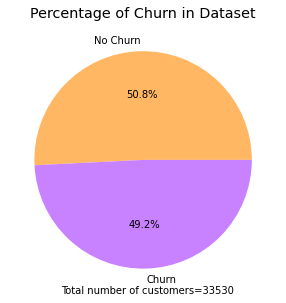

In [31]:
%matplotlib inline
# Data to plot
sizes = df['churn'].value_counts(sort = True)
rcParams['figure.figsize'] = 5,5
# Plot
plt.pie(sizes,labels=['No Churn','Churn'],
        autopct='%1.1f%%',colors=['#ffb763','#c982ff'])
plt.title('Percentage of Churn in Dataset')
plt.text(plt.xlim()[0]+0.5, plt.ylim()[0], "Total number of customers=33530", ha ='left', fontsize = 10,verticalalignment='bottom')
plt.savefig('churn_percent.png')
plt.show()

In [32]:
f, ax = plt.subplots(figsize=(50,30))
sns.heatmap(corr_matrix, annot=True)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

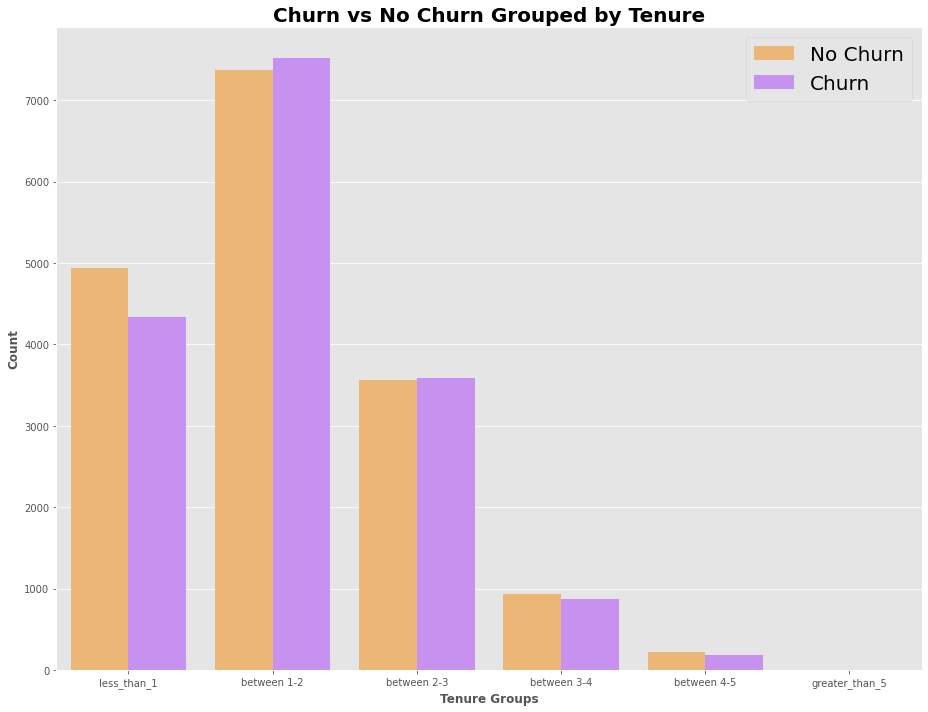

In [33]:
df=df.rename(columns={"months": "tenure"})
def tenure_groups(df):
    if df.tenure <= 12:
        return "less_than_1"
    elif (df.tenure > 12) & (df.tenure <= 24):
        return "between 1-2"
    elif (df.tenure > 24) & (df.tenure <= 36):
        return "between 2-3"
    elif (df.tenure > 36) & (df.tenure <= 48):
        return "between 3-4"
    elif (df.tenure > 48) & (df.tenure <= 60):
        return "between 4-5"
    else:
        return "greater_than_5"
df['grouped_tenure'] = df.apply(lambda df: tenure_groups(df), axis = 1)

plt.figure(figsize = (13,10))
t = sns.countplot(data = df, x = 'grouped_tenure',  hue = 'churn', order = ['less_than_1', "between 1-2","between 2-3","between 3-4","between 4-5",'greater_than_5'],palette=['#ffb763','#c982ff'])
t.set_title('Churn vs No Churn Grouped by Tenure', fontsize = 20, fontweight = 'bold')
t.set_xlabel('Tenure Groups', fontweight = 'bold')
t.set_ylabel('Count',fontweight='bold')
t.legend(loc = 'upper right', fontsize = 20, labels = ['No Churn', 'Churn'])
plt.tight_layout()
plt.savefig('tenure.png')

df=df.drop(['grouped_tenure'], axis = 1)

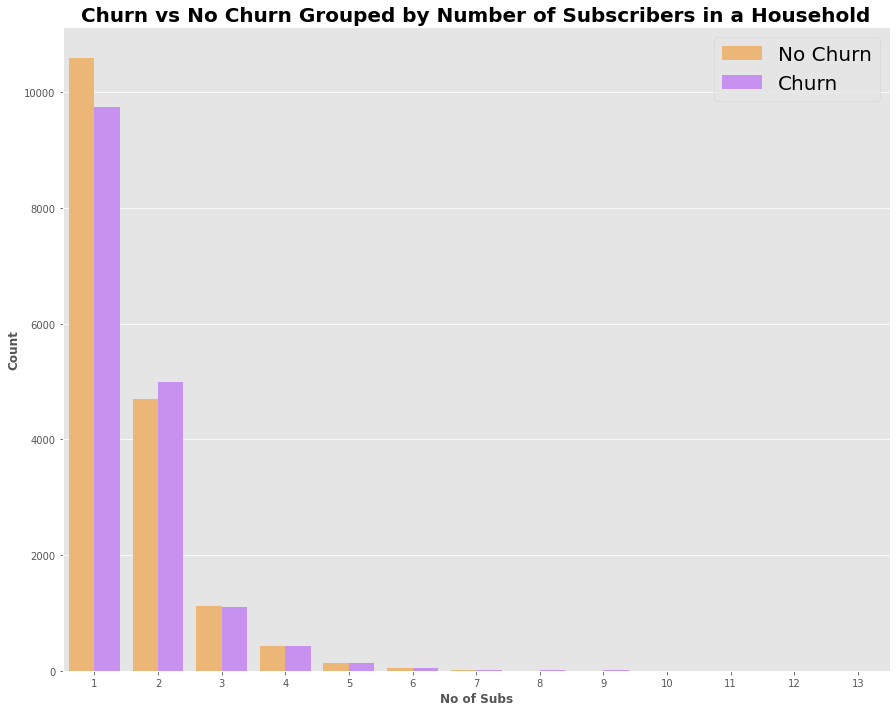

In [34]:

plt.figure(figsize = (13,10))
t = sns.countplot(data = df, x = 'uniqsubs',  hue = 'churn',palette=['#ffb763','#c982ff'])
t.set_title('Churn vs No Churn Grouped by Number of Subscribers in a Household', fontsize = 20, fontweight = 'bold')
t.set_xlabel('No of Subs', fontweight = 'bold')
t.set_ylabel('Count',fontweight='bold')
t.legend(loc = 'upper right', fontsize = 20, labels = ['No Churn', 'Churn'])
plt.tight_layout()
plt.savefig('subs.png')


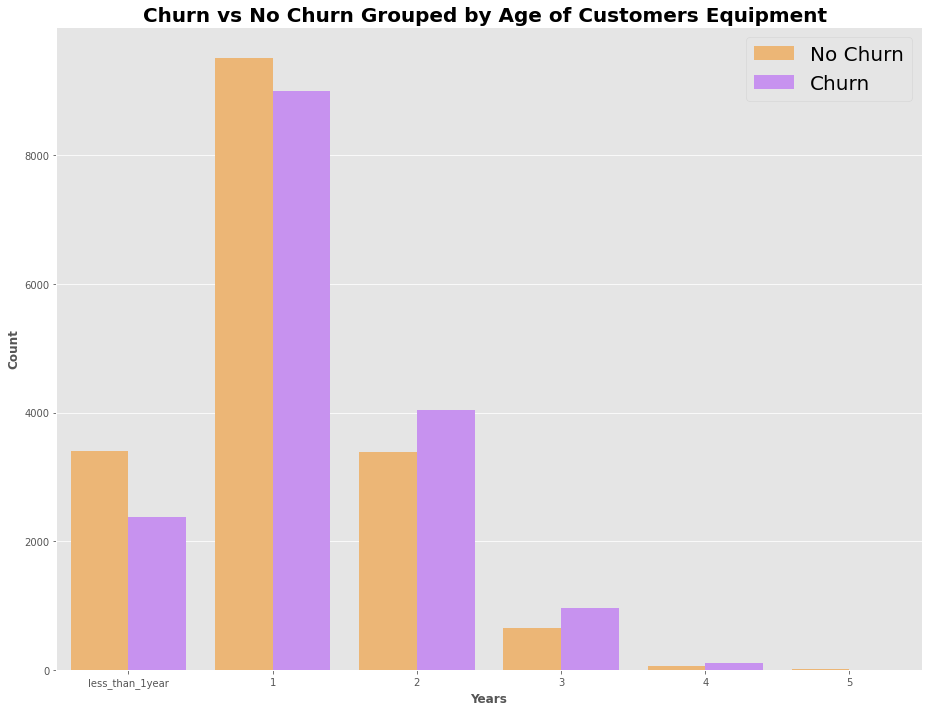

In [35]:
df['eqpyears']=round(df['eqpdays']/365,0)
def lessthanone(df):
  if df.eqpyears<1:
    return 'less_than_1year'
  else:
    return df.eqpyears
df['eqpy'] = df.apply(lambda df: lessthanone(df), axis = 1)
plt.figure(figsize = (13,10))
t = sns.countplot(data = df, x = 'eqpy',  hue = 'churn',order=['less_than_1year',1,2,3,4,5],palette=['#ffb763','#c982ff'])
t.set_title('Churn vs No Churn Grouped by Age of Customers Equipment ', fontsize = 20, fontweight = 'bold')
t.set_xlabel('Years', fontweight = 'bold')
t.set_ylabel('Count',fontweight='bold')
t.legend(loc = 'upper right', fontsize = 20, labels = ['No Churn', 'Churn'])
plt.tight_layout()
plt.savefig('eqp.png')
df=df.drop(['eqpyears','eqpy'],axis=1)




*   Kernel Density Estimator plots will show probability density functions of variables relative to churn variable
*   KDE plots will provide us a region where is the highest likelyhood of a new datapoint.



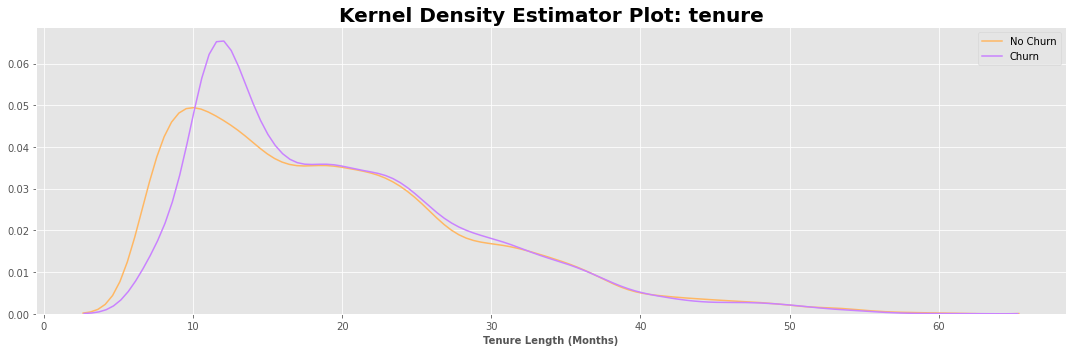

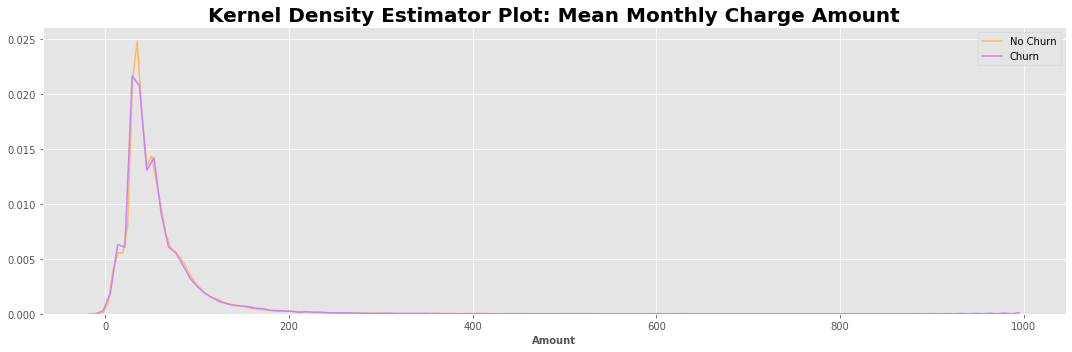

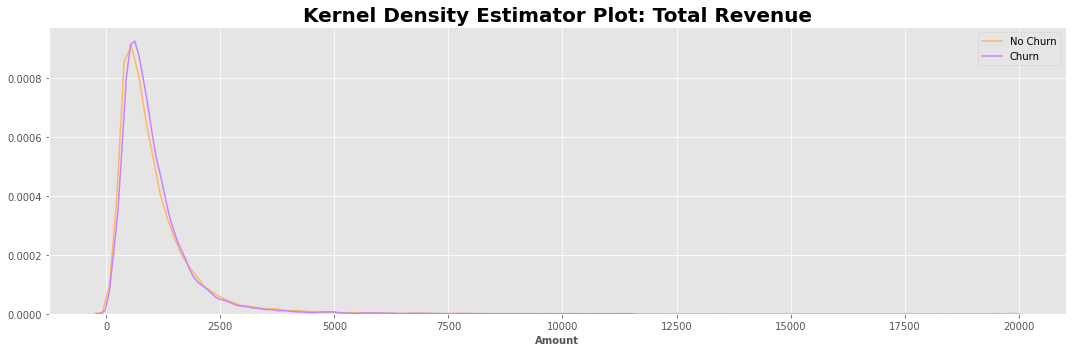

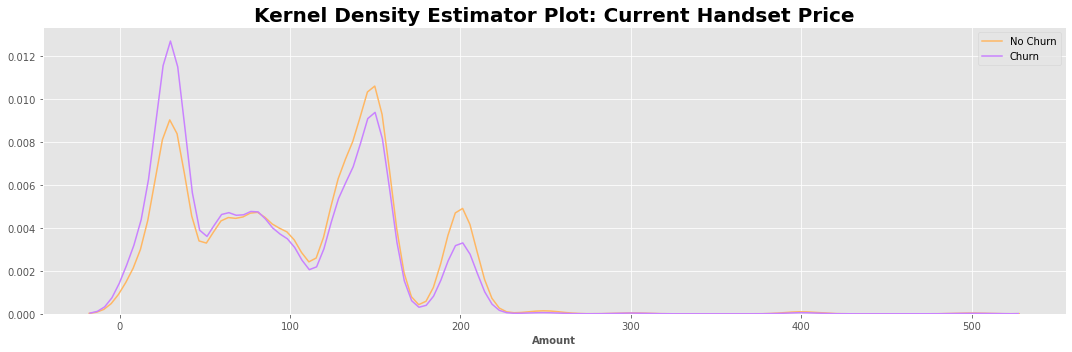

In [36]:

def plot_kde(df, feature):
    plt.figure(figsize = (15, 5))
    plt.title(f"Kernel Density Estimator Plot: {feature}", fontsize = 20, fontweight = 'bold')
    ax = sns.kdeplot(df[df.churn == 0][feature].dropna(), label = 'No Churn', legend = True,color='#ffb763')
    plt.legend = True
    ax1 = sns.kdeplot(df[df.churn == 1][feature].dropna(), label = 'Churn', legend = True, color='#c982ff')
    if feature == 'tenure':
        plt.xlabel('Tenure Length (Months)', fontsize = 10, fontweight = 'bold')
    else:
        plt.xlabel('Amount', fontsize = 10, fontweight = 'bold')
    plt.tight_layout()
    plt.savefig(feature)
df=df.rename(columns={"rev_Mean": "Mean Monthly Charge Amount", "totrev": "Total Revenue","hnd_price":"Current Handset Price"})
plot_kde(df, 'tenure')
plot_kde(df, 'Mean Monthly Charge Amount')
plot_kde(df, 'Total Revenue')
plot_kde(df,'Current Handset Price')

## **MODELS**

In [37]:
# Establish target feature, churn
y = df.churn.values
X = df.drop(['churn'], axis = 1)
cols = X.columns



*   To shorten the training times of the models and stabilize the models, I apply minmax normalization which rescales the range of the data to [0,1].




In [38]:
from sklearn.preprocessing import MinMaxScaler
# Instantiate a Min-Max scaling object
mm = MinMaxScaler()
# Fit and transform our feature data into a pandas dataframe
X = pd.DataFrame(mm.fit_transform(X))

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)


**Logistic Regression**

In [40]:
#We want to begin our analysis with logistic reg model as a primitive model
from sklearn.linear_model import LogisticRegression
# If we use logistic regression without liblinear solver the model fails to converge hence 
logreg = LogisticRegression(solver = 'liblinear')
# Fit the model to our X and y training sets
logreg.fit(X_train, y_train)
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, roc_auc_score
def print_metrics(y_train, y_hat_train, y_test, y_hat_test):
    print('Training Metrics:')
    print(f'Training Precision: ', round(precision_score(y_train, y_hat_train), 2))
    print(f'Training Recall: ', round(recall_score(y_train, y_hat_train), 2))
    print(f'Training Accuracy: ', round(accuracy_score(y_train, y_hat_train), 2))
    print(f'Training F1-Score: ', round(f1_score(y_train, y_hat_train), 2))
    print(f'Testing Metrics:')
    print(f'Testing Precision: ', round(precision_score(y_test, y_hat_test),2))
    print(f'Testing Recall: ', round(recall_score(y_test, y_hat_test),2))
    print(f'Testing Accuracy: ', round(accuracy_score(y_test, y_hat_test),2))
    print(f'Testing F1-Score: ', round(f1_score(y_test, y_hat_test),2))
print_metrics(y_train, y_hat_train, y_test, y_hat_test)

Training Metrics:
Training Precision:  0.6
Training Recall:  0.58
Training Accuracy:  0.61
Training F1-Score:  0.59
Testing Metrics:
Testing Precision:  0.59
Testing Recall:  0.57
Testing Accuracy:  0.59
Testing F1-Score:  0.58


Training AUC: 0.6429124190242081
Test AUC: 0.6249751040884325


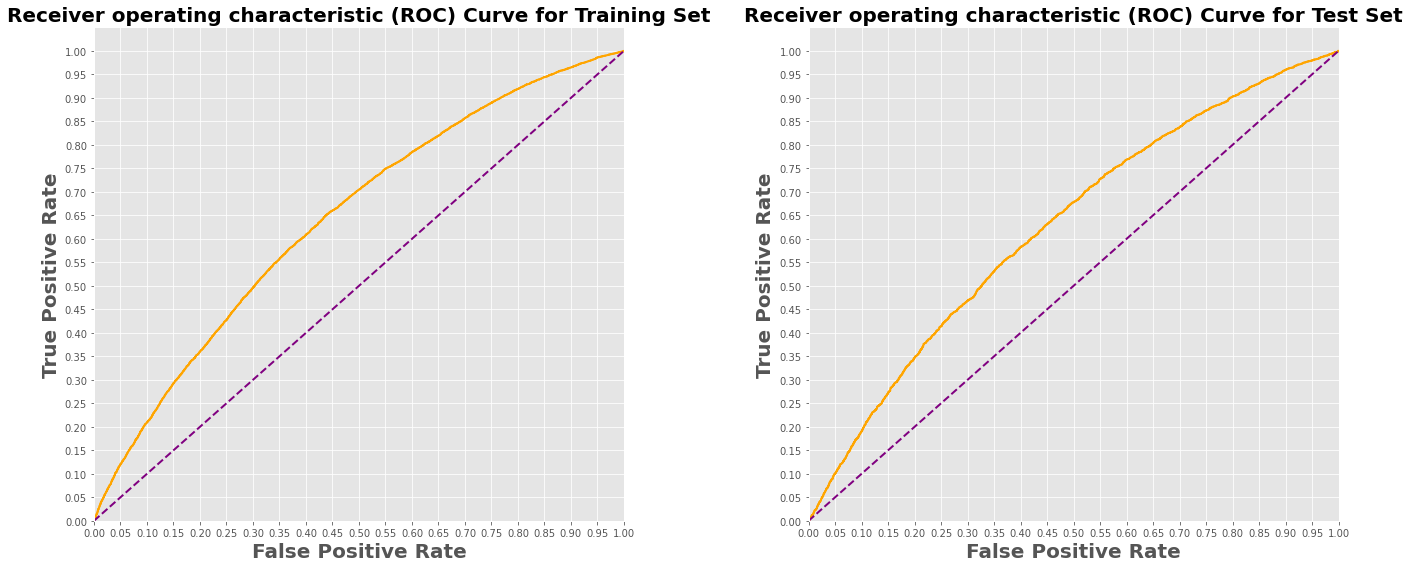

In [42]:
from sklearn.metrics import roc_curve, auc
def plot_auc(model, X_train, X_test, y_train, y_test):
    
   
    y_train_score = model.decision_function(X_train)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    y_test_score = model.decision_function(X_test)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    
    # Print Area-Under-Curve scores
    print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    
    plt.figure(figsize = (20, 8))
    lw = 2
    
    #train data AUC curve 
    plt.subplot(121)
    plt.plot(train_fpr, train_tpr, color = 'orange', lw = lw, label = 'ROC Curve')
   
    plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
    plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
    plt.title('Receiver operating characteristic (ROC) Curve for Training Set', fontweight = 'bold', fontsize = 20)
   

    # test data AUC curve
    plt.subplot(122)
    plt.plot(test_fpr, test_tpr, color='orange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='purple', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.ylabel('True Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.title('Receiver operating characteristic (ROC) Curve for Test Set', fontweight = 'bold', fontsize = 20)
    plt.tight_layout()

plot_auc(logreg, X_train, X_test, y_train, y_test)

**KNN model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNN object
knn1 = KNeighborsClassifier()
knn1.fit(X_train, y_train)
test_preds1 = knn1.predict(X_test)

In [ ]:

# Calculate (accuracy) score metric
knn1.score(X_test, y_test)

print(f"Precision Score: {precision_score(y_test, test_preds1)}")
print(f"Recall Score: {recall_score(y_test, test_preds1)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds1)}")
print(f"F1 Score: {f1_score(y_test, test_preds1)}")

Precision Score: 0.5305425032037591
Recall Score: 0.49620455453455853
Accuracy Score: 0.5307684660503033
F1 Score: 0.5127993393889348


AUC Score: 0.5306077195787774


Text(0.5, 1.0, 'ROC Curve: KNN Classifier')

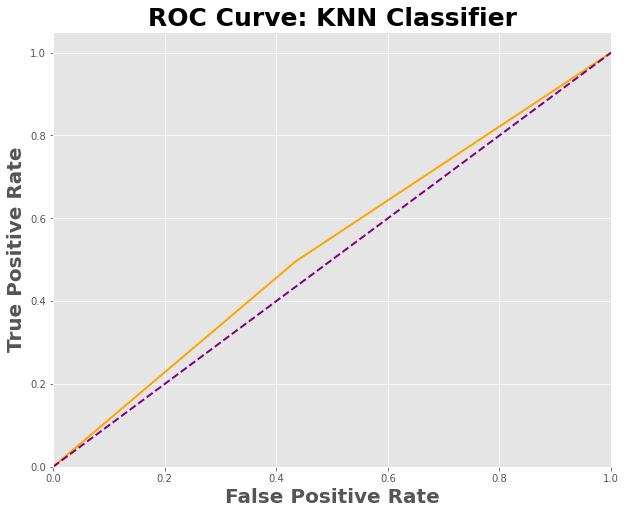

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, test_preds1)
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

# Plot AUC curve
plt.style.use('ggplot')
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, lw = 2, label = 'Baseline AUC ='+str(roc_auc),color='orange')
plt.plot([0,1],[0,1], linestyle = '--', lw = 2, color='purple')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
plt.title('ROC Curve: KNN Classifier', fontsize = 25, fontweight = 'bold')

**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(random_state = 42)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
test_preds1 = clf1.predict(X_test)

In [ ]:
print(f"Precision Score: {precision_score(y_test, test_preds1)}")
print(f"Recall Score: {recall_score(y_test, test_preds1)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds1)}")
print(f"F1 Score: {f1_score(y_test, test_preds1)}")

Precision Score: 0.5495059487799959
Recall Score: 0.5443467838593687
Accuracy Score: 0.5511482254697286
F1 Score: 0.5469141996989462


In [ ]:
pd.crosstab(y_test, test_preds1, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,2819,2234,5053
1,2281,2725,5006
All,5100,4959,10059


AUC Score: 0.5511165939878676


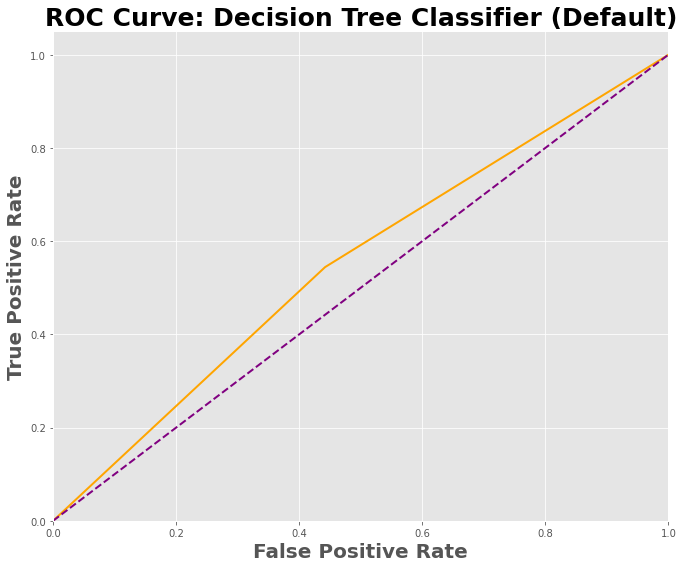

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, test_preds1)
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

# Plot AUC curve
plt.style.use('ggplot')
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, lw = 2, label = 'Baseline AUC ='+str(roc_auc),color='orange')
plt.plot([0,1],[0,1], linestyle = '--', lw = 2,color='purple')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
plt.title('ROC Curve: Decision Tree Classifier (Default)', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

**Decision Tree with hyperparameter tuning**

***if you want to run grid search for parameters and get best parameter and best score by yourself run following cell otherwise skip this cell***

In [ ]:
#Finding best model parameters with grid search
from sklearn.model_selection import GridSearchCV, cross_val_score
clf3 = DecisionTreeClassifier(random_state = 42)
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_split':[20, 25, 30, 35, 40],
    'min_samples_leaf':[1,2,3,4,5,6]
}
gs_tree = GridSearchCV(clf3, param_grid, cv = 4, verbose = True)
gs_tree.fit(X_train, y_train)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 37.9min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [ ]:
print(f"Best Parameters: {gs_tree.best_params_}")
print(f"Best Score: {gs_tree.best_score_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 25}
Best Score: 0.5955859384848579


In [ ]:
dec_tree=DecisionTreeClassifier(criterion='entropy',max_depth=5,min_samples_leaf=6,min_samples_split=4)
dec_tree.fit(X_train,y_train)
dec_tree_preds = dec_tree.predict(X_test)

In [ ]:
print(f"Precision Score: {precision_score(y_test, dec_tree_preds)}")
print(f"Recall Score: {recall_score(y_test,  dec_tree_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test,  dec_tree_preds)}")
print(f"F1 Score: {f1_score(y_test,  dec_tree_preds)}")

Precision Score: 0.5875313646014283
Recall Score: 0.6080703156212545
Accuracy Score: 0.5925042250720748
F1 Score: 0.5976244232845783


In [ ]:
fpr, tpr, threshold = roc_curve(y_test, dec_tree_preds)
# Calculate AUC score from sklearn.metrics library
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

AUC Score: 0.5925766183291311


**Random Forest**

In [46]:
from sklearn.ensemble import RandomForestClassifier

***if you want to run grid search for parameters and get best parameter and best score by yourself run following cell otherwise skip this cell***

In [ ]:

rfc1 = RandomForestClassifier()
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'n_estimators':[100,120,140,150,200]
}
randomfor = GridSearchCV(rfc1, param_grid, cv = 4, verbose = True)
randomfor.fit(X_train, y_train)
print(f"Best Parameters: {randomfor.best_params_}")
print(f"Best Score: {randomfor.best_score_}")

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 44.1min finished


Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 200}
Best Score: 0.6209363583636318


In [47]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=15,n_estimators=200)
rfc.fit(X_train,y_train)
rfc_preds=rfc.predict(X_test)
print(f"Precision Score: {precision_score(y_test, rfc_preds)}")
print(f"Recall Score: {recall_score(y_test,  rfc_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test,  rfc_preds)}")
print(f"F1 Score: {f1_score(y_test,  rfc_preds)}")
fpr, tpr, threshold = roc_curve(y_test, rfc_preds)
# Calculate AUC score from sklearn.metrics library
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

Precision Score: 0.6111111111111112
Recall Score: 0.6108669596484219
Accuracy Score: 0.6128839844915002
F1 Score: 0.610989010989011
AUC Score: 0.612874603908913


**Xgboost** 

In [ ]:
import xgboost as xgb
xgb_model1 = xgb.XGBClassifier(objective="binary:logistic", random_state=42,tree_method='gpu_hist')
xgb_model1.fit(X_train, y_train)

xgb_preds = xgb_model1.predict(X_test)
print(f"Precision Score: {precision_score(y_test, xgb_preds)}")
print(f"Recall Score: {recall_score(y_test,  xgb_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test,  xgb_preds)}")
print(f"F1 Score: {f1_score(y_test,  xgb_preds)}")
fpr, tpr, threshold = roc_curve(y_test, xgb_preds)
# Calculate AUC score from sklearn.metrics library
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

Precision Score: 0.6228995701445877
Recall Score: 0.6368357970435478
Accuracy Score: 0.6273983497365543
F1 Score: 0.6297905966021335
AUC Score: 0.6274422404968382


**Xgboost with hyperparameter tuning**

***if you want to run grid search for parameters and get best parameter and best score by yourself run following cell otherwise skip this cell***

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import  RandomizedSearchCV

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model1, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X_train, y_train)


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  9.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8d3fa47dd8>,
                                        'max_dep

In [ ]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.632 (std: 0.002)
Parameters: {'colsample_bytree': 0.8873062144401379, 'gamma': 0.147816842918857, 'learning_rate': 0.06164827794908118, 'max_depth': 5, 'n_estimators': 127, 'subsample': 0.6873761748867334}



In [44]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",colsample_bytree= 0.827, gamma= 0.215, learning_rate=  0.129, max_depth= 4, n_estimators= 101, subsample= 0.877,random_state=42)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)
print(f"Precision Score: {precision_score(y_test, xgb_preds)}")
print(f"Recall Score: {recall_score(y_test,  xgb_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test,  xgb_preds)}")
print(f"F1 Score: {f1_score(y_test,  xgb_preds)}")
fpr, tpr, threshold = roc_curve(y_test, xgb_preds)
roc_auc = auc(fpr, tpr)

print(f'AUC Score: {roc_auc}')

Precision Score: 0.6244809175400435
Recall Score: 0.6308429884139033
Accuracy Score: 0.6274977631971369
F1 Score: 0.627645831263043
AUC Score: 0.6275133208445927


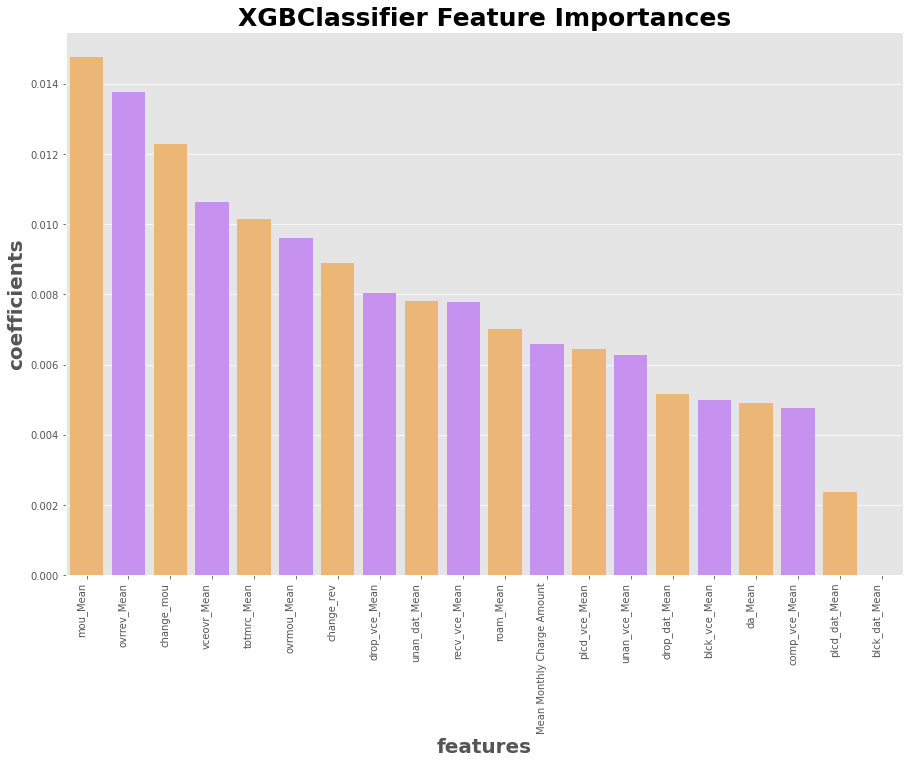

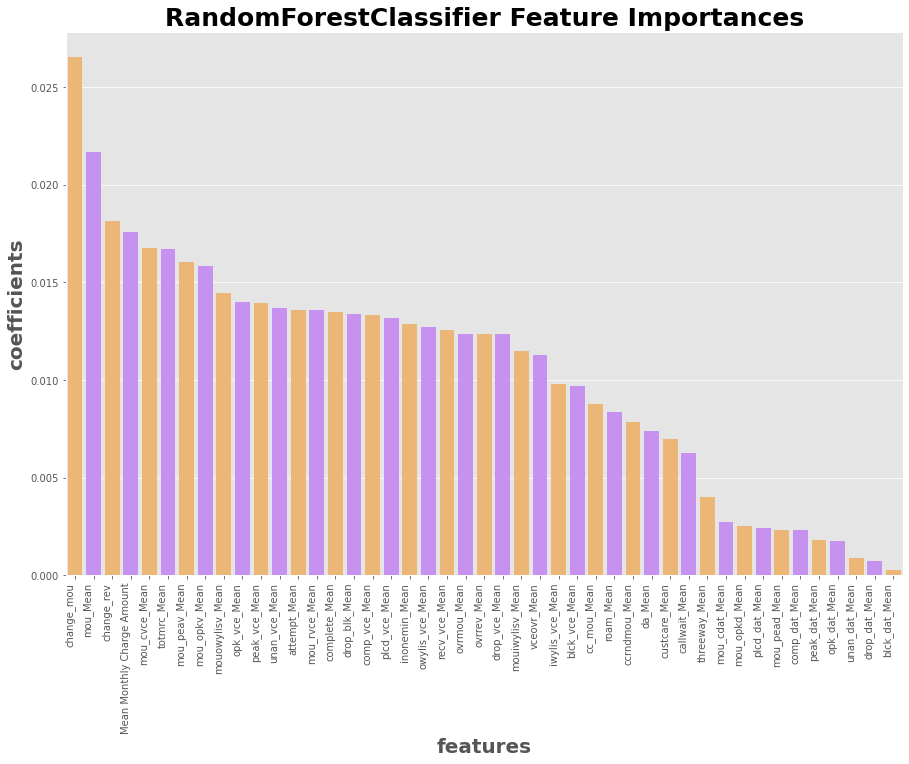

In [62]:
def feature_imp(algorithm,cf):
  if   cf == "coefficients" :
    coefficients  = pd.DataFrame(algorithm.coef_.ravel())
  elif cf == "features" :
    coefficients  = pd.DataFrame(algorithm.feature_importances_)
  column_df     = pd.DataFrame(cols)
  coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
  coef_sumry.columns = ["coefficients","features"]
  coef_sumry = coef_sumry.sort_values(by = "coefficients",ascending = False)
  for counter,value in enumerate(coef_sumry['coefficients']):
    if np.absolute(value)<0.01:
      coef_sumry=coef_sumry.drop(counter,axis=0)   
  plt.figure(figsize = (15,10))
  plt.xlabel('Features', fontsize = 20, fontweight = 'bold')
  plt.ylabel('Coefficients', fontsize = 20, fontweight = 'bold')
  plt.title(str(algorithm)[:str(algorithm).find('(')]+' Feature Importances', fontsize = 25, fontweight = 'bold')
  feats = sns.barplot(x = coef_sumry["features"],y = coef_sumry["coefficients"],palette=['#ffb763','#c982ff'])
  feats.set_xticklabels(feats.get_xticklabels(), rotation=90, horizontalalignment='right')
feature_imp(xgb_model,"features")
plt.savefig('xgboost_feature_imp.png')
feature_imp(rfc,"features")
plt.savefig('rfc_feature_imp.png')

## **RESULTS SUMMARY**

In [ ]:

def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "F1_score"        : [f1score],
                       "AUC": [roc_auc],
                       
                      })
    return df

#outputs for every model
model1 = model_report(logreg,X_train,X_test,y_train,y_test,"Logistic Regression")
model2 = model_report(knn1,X_train,X_test,y_train,y_test,
                      "KNN Classifier")
                      
model3 = model_report(clf1,X_train,X_test,y_train,y_test,
                      "Decision Tree (base)")
model4 = model_report(dec_tree,X_train,X_test,y_train,y_test,
                      "Decision Tree(tuned)")

model5 = model_report(rfc,X_train,X_test,y_train,y_test,
                      "Random Forest Classifier(tuned)")

model6 = model_report(xgb_model1,X_train,X_test,y_train,y_test,
                      "XGBoost Classifier(base)")

model7 = model_report(xgb_model,X_train,X_test,y_train,y_test,
                      "XGBoost Classifier(tuned)")
#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model6,
                                model7],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

In [ ]:
model_performances

,Model,Accuracy_score,Recall_score,Precision,F1_score,AUC
0,Logistic Regression,0.589820,0.570316,0.591097,0.580521,0.589729
1,KNN Classifier,0.526494,0.496804,0.525682,0.510835,0.526356
2,Decision Tree (base),0.551148,0.544347,0.549506,0.546914,0.551117
3,Decision Tree(tuned),0.592504,0.608070,0.587531,0.597624,0.592577
4,Random Forest Classifier(tuned),0.616264,0.609069,0.615711,0.612372,0.616231
5,XGBoost Classifier(base),0.624615,0.634439,0.620070,0.627172,0.624660
6,XGBoost Classifier(tuned),0.627498,0.630843,0.624481,0.627646,0.627513
